Adapted from **Analyzing Baseball Data with R**, by Marchi and Albert (CRC Press)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = '../data/lahman-csv_2015-01-24/'

In [2]:
teams = pd.read_csv(DATA_DIR+'Teams.csv')
teams.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,...,NaN,0.83,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,...,NaN,0.82,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,...,NaN,0.81,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,...,NaN,0.80,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,...,NaN,0.83,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


In [178]:
since_2001 = teams.loc[teams.yearID > 2000, ['teamID', 'yearID', 'lgID', 'G', 'W', 'L', 'R', 'RA']]
since_2001.head()

,teamID,yearID,lgID,G,W,L,R,RA
2355,ANA,2001,AL,162,75,87,691,730
2356,ARI,2001,NL,162,92,70,818,677
2357,ATL,2001,NL,162,88,74,729,643
2358,BAL,2001,AL,162,63,98,687,829
2359,BOS,2001,AL,161,82,79,772,745


In [179]:
since_2001 = since_2001.assign(RD=since_2001.R - since_2001.RA, Wpct=since_2001.W / (since_2001.W + since_2001.L))

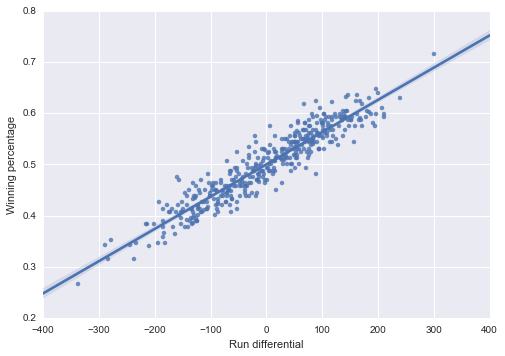

In [180]:
axes = sns.regplot(since_2001.RD, since_2001.Wpct)
axes.set_xlabel('Run differential')
axes.set_ylabel('Winning percentage')

Bayesian regression using PyMC3:

Assigned NUTS to Intercept
Assigned NUTS to RD
Assigned NUTS to sd_log
 [-----------------100%-----------------] 1000 of 1000 complete in 5.4 sec
Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.499            0.021            0.001            [0.498, 0.502]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.497          0.499          0.500          0.501          0.502


RD:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.001            0.000            0.000            [0.001, 0.001]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.001          0.001       

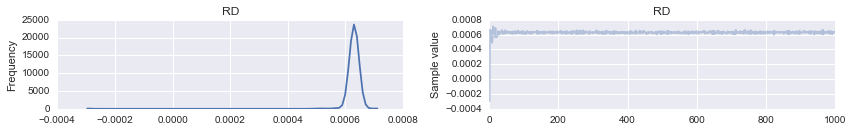

In [244]:
import pymc3 as pm

with pm.Model() as run_model:
    
    pm.glm.glm('Wpct ~ RD', since_2001)
    trace = pm.sample(1000)
    pm.traceplot(trace, vars=['RD'])
    pm.summary(trace)

In [245]:
with pm.Model() as run_model_resid:
    
    β = pm.Normal('β', 0, 1e-6, shape=2)
    μ = β[0] + β[1] * since_2001.RD
    σ = pm.Uniform('σ', 0, 100)
    
    wp = pm.Normal('wp', μ, σ**-2, observed=since_2001.Wpct)
    
    ϵ = pm.Deterministic('ϵ', since_2001.Wpct.values - μ)
    
    trace = pm.sample(2000)

Assigned NUTS to β
Assigned NUTS to σ_interval
 [-----------------100%-----------------] 2000 of 2000 complete in 52.4 sec

In [246]:
pm.summary(trace[1000:], vars=['β'], roundto=6)


β:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.500048         0.001280         0.000035         [0.497660, 0.502642]
  0.000631         0.000012         0.000000         [0.000609, 0.000653]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.497619       0.499232       0.500027       0.500872       0.502616
  0.000607       0.000622       0.000631       0.000639       0.000652



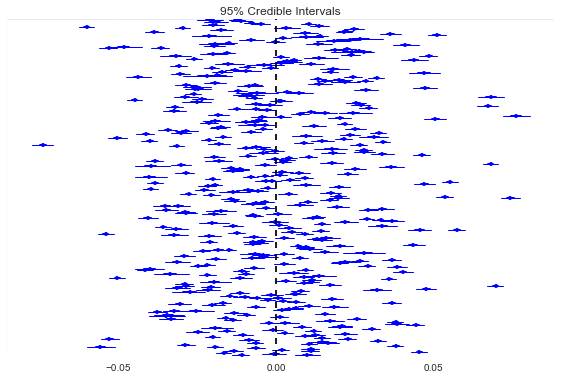

In [247]:
pm.forestplot(trace[1000:], vars=['ϵ'], ylabels=['']*len(since_2001))

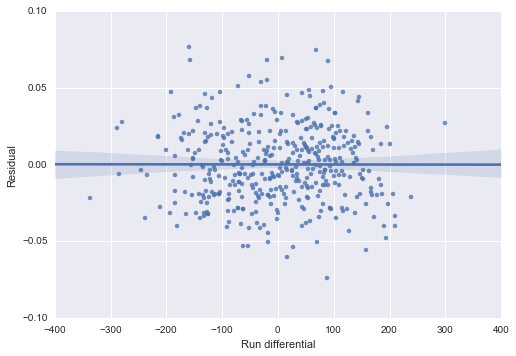

In [248]:
axes = sns.regplot(since_2001.RD, trace['ϵ'][1000:].mean(axis=0))
axes.set_ylabel('Residual')
axes.set_xlabel('Run differential')

Using scikit-learn:

In [182]:
from sklearn import linear_model

Wpct = since_2001.Wpct.values
RD = since_2001.RD.reshape(-1,1)

regr = linear_model.LinearRegression()
regr.fit(RD, Wpct, since_2001.Wpct)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [183]:
regr.coef_

array([ 0.00062709])

In [184]:
Wpct_hat = regr.predict(RD)
ϵ = Wpct - Wpct_hat

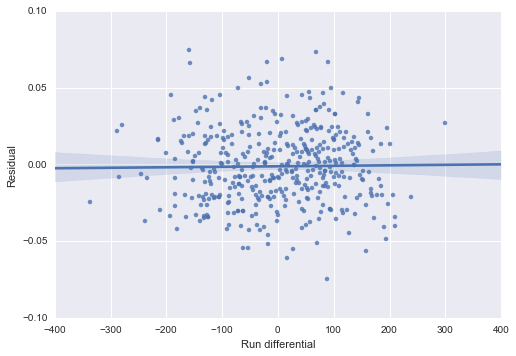

In [185]:
axes = sns.regplot(since_2001.RD, ϵ)
axes.set_ylabel('Residual')
axes.set_xlabel('Run differential')

In [186]:
regr.score(RD, Wpct)

0.88003554784382143

Root mean squared error (RMSE)

In [187]:
rmse = np.sqrt((ϵ**2).mean())

In [188]:
(np.abs(ϵ) < rmse).mean()

0.69285714285714284

In [189]:
(np.abs(ϵ) < 2*rmse).mean()

0.95714285714285718

Pythagorean wins for SF

In [243]:
R, RA = since_2001[['R', 'RA']].T.values
since_2001 = since_2001.assign(pythWins=162 * R**2 / (RA**2 + R**2))

In [191]:
since_2001[(since_2001.teamID=='SFN') & (since_2001.yearID==2011)]

,teamID,yearID,lgID,G,W,L,R,RA,RD,Wpct,pythWins
2679,SFN,2011,NL,162,86,76,570,578,-8,0.530864,79.871135


Load 2011 game logs

In [192]:
games_2011 = pd.read_csv('../data/gl2011.txt', header=None)
games_2011.columns = pd.read_csv('../data/game_log_header.txt', header=None).values[0]
games_2011.head()

,Date,DoubleHeader,DayOfWeek,VisitingTeam,VisitingTeamLeague,VisitingTeamGameNumber,HomeTeam,HomeTeamLeague,HomeTeamGameNumber,VisitorRunsScored,...,HomeBatting7Name,HomeBatting7Position,HomeBatting8PlayerID,HomeBatting8Name,HomeBatting8Position,HomeBatting9PlayerID,HomeBatting9Name,HomeBatting9Position,AdditionalInfo,AcquisitionInfo
0,20110331,0,Thu,MIL,NL,1,CIN,NL,1,6,...,Ramon Hernandez,2,janip001,Paul Janish,6,volqe001,Edinson Volquez,1,NaN,Y
1,20110331,0,Thu,SFN,NL,1,LAN,NL,1,1,...,Rod Barajas,2,carrj001,Jamey Carroll,4,kersc001,Clayton Kershaw,1,NaN,Y
2,20110331,0,Thu,SDN,NL,1,SLN,NL,1,5,...,Yadier Molina,2,schus001,Skip Schumaker,4,carpc002,Chris Carpenter,1,NaN,Y
3,20110331,0,Thu,ATL,NL,1,WAS,NL,1,2,...,Danny Espinosa,4,rodri001,Ivan Rodriguez,2,hernl003,Livan Hernandez,1,NaN,Y
4,20110331,0,Thu,ANA,AL,1,KCA,AL,1,4,...,Alcides Escobar,6,tream001,Matt Treanor,2,getzc001,Chris Getz,4,NaN,Y


In [193]:
SF2011 = games_2011.loc[(games_2011.HomeTeam=='SFN') | (games_2011.VisitingTeam=='SFN'), 
                   ("VisitingTeam", "HomeTeam", "VisitorRunsScored", "HomeRunsScore")]
SF2011 

,VisitingTeam,HomeTeam,VisitorRunsScored,HomeRunsScore
1,SFN,LAN,1,2
9,SFN,LAN,3,4
21,SFN,LAN,10,0
35,SFN,LAN,5,7
58,SFN,SDN,1,3
72,SFN,SDN,8,4
97,SLN,SFN,4,5
111,SLN,SFN,2,3
127,SLN,SFN,6,1
139,LAN,SFN,6,1


Calculate SF score differences

In [194]:
SF2011 = SF2011.assign(ScoreDiff=np.where(SF2011.HomeTeam=='SFN', SF2011.HomeRunsScore - SF2011.VisitorRunsScored, 
                                 SF2011.VisitorRunsScored - SF2011.HomeRunsScore))
SF2011 = SF2011.assign(Outcome=(SF2011.ScoreDiff > 0).replace({True:'win', False:'loss'}))

In [195]:
SF2011.groupby('Outcome').apply(lambda x: x.ScoreDiff.describe())

ScoreDiff,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
loss,76,-3.223684,2.436384,-13,-5,-3,-1,-1
win,86,2.755814,2.233099,1,1,2,3,12


array([<matplotlib.axes._subplots.AxesSubplot object at 0x112605198>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x116135ef0>], dtype=object)

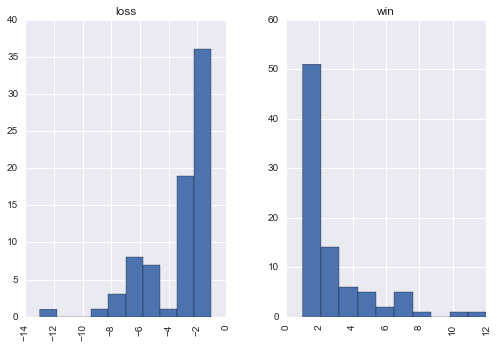

In [196]:
SF2011.hist(column='ScoreDiff', by='Outcome')

Losses were decided by larger margin than wins, leading to overperformance versus Pythagorean formula.

### Pythagorean wins exponent model

In [253]:
with pm.Model() as pythag_model:
    
    exp = pm.Uniform('exp', 0, 5)
    
    pyth_wins = pm.Deterministic('pyth_wins', 162 * R**exp / (RA**exp + R**exp))
    
    wins = pm.Poisson('wins', pyth_wins, observed=since_2001.W.values)
    
    trace = pm.sample(2000)

Assigned NUTS to exp_interval
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120324dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11db84d68>]], dtype=object)

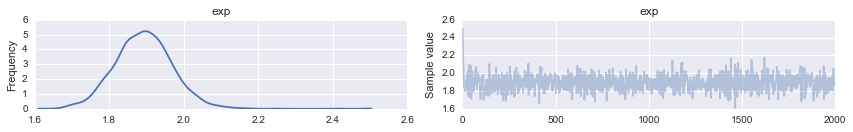

In [254]:
pm.traceplot(trace, vars=['exp'])

In [255]:
pm.summary(trace, vars=['exp'])


exp:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.893            0.079            0.003            [1.741, 2.040]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.744          1.842          1.892          1.941          2.046



### One-run games

In [203]:
results = games_2011[['VisitingTeam', 'HomeTeam', 'VisitorRunsScored', 'HomeRunsScore']]

In [204]:
results = results.assign(Winner=results.HomeTeam.where(results.HomeRunsScore > results.VisitorRunsScored, 
                                                       results.VisitingTeam),
                        Difference=np.abs(results.VisitorRunsScored - results.HomeRunsScore))

In [205]:
results.head()

,VisitingTeam,HomeTeam,VisitorRunsScored,HomeRunsScore,Difference,Winner
0,MIL,CIN,6,7,1,CIN
1,SFN,LAN,1,2,1,LAN
2,SDN,SLN,5,3,2,SDN
3,ATL,WAS,2,0,2,ATL
4,ANA,KCA,4,2,2,ANA


In [206]:
one_run_games = results.query('Difference==1').Winner.value_counts()
one_run_games.name = 'OneRunGames'

Merge with residuals table

In [207]:
one_run_games.head()

SFN    33
CLE    30
MIL    30
DET    29
CIN    29
Name: OneRunGames, dtype: int64

In [208]:
teams_2011 = since_2001.query('yearID==2011').set_index('teamID').join(one_run_games)

In [211]:
teams_2011 = teams_2011.assign(pythResid=teams_2011.W - teams_2011.pythWins)

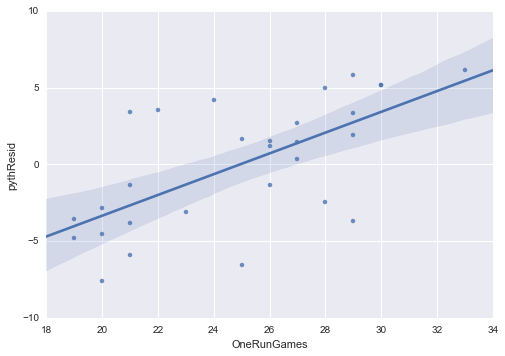

In [212]:
sns.regplot(teams_2011.OneRunGames, teams_2011.pythResid, 'ro')

Relationship between one-run wins and relief pitching

In [213]:
pitching = pd.read_csv('../data/lahman-csv_2015-01-24/Pitching.csv')
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN


In [216]:
top_closers = pitching.query('GF > 50 & ERA < 2.5')[["playerID", "yearID", "teamID"]]

In [223]:
top_closers[top_closers.yearID==2011].set_index('teamID')

,playerID,yearID
teamID,,
MIL,axforjo01,2011
SDN,bellhe01,2011
CIN,cordefr01,2011
TBA,farnsky01,2011
PIT,hanrajo01,2011
ATL,kimbrcr01,2011
ARI,putzjj01,2011
NYA,riverma01,2011
DET,valvejo01,2011


In [234]:
teams_2011.head()

,yearID,lgID,G,W,L,R,RA,RD,Wpct,pythWins,OneRunGames,pythResid
teamID,,,,,,,,,,,,
ARI,2011,NL,162,94,68,731,662,69,0.580247,89.004768,28,4.995232
ATL,2011,NL,162,89,73,641,605,36,0.549383,85.676674,29,3.323326
BAL,2011,AL,162,69,93,708,860,-152,0.425926,65.442118,22,3.557882
BOS,2011,AL,162,90,72,875,737,138,0.555556,94.767588,19,-4.767588
CHA,2011,AL,162,79,83,654,706,-52,0.487654,74.814925,24,4.185075


In [241]:
top_closers_merged = top_closers[top_closers.yearID==2011].set_index('teamID').join(teams_2011, lsuffix='_a', rsuffix='_b')

In [242]:
top_closers_merged.pythResid.describe()

count    9.000000
mean     0.464949
std      5.166120
min     -7.578614
25%     -3.669926
50%      3.323326
75%      4.995232
max      5.802142
Name: pythResid, dtype: float64